In [9]:
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets.mnist
import models
import datasets as ds
import audio_processor as ap
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import torchvision.datasets as datasets
from torch import nn
from tqdm import tqdm
from torchmetrics import *
import pandas as pd
import torchaudio.transforms as aT
import csv

In [34]:
def get_data_loaders(trainset, testset, batch_size=16,
                     shuffle_trainset=True, shuffle_testset=False):
    if trainset is not None:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=shuffle_trainset)
    else:
        trainloader = None

    if testset is not None:
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                  shuffle=shuffle_testset)
    else:
        testloader = None

    return trainloader, testloader

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    t = np.transpose(npimg, (1, 2, 0))
    plt.imshow(t, cmap='gray', vmin=0, vmax=1)
    plt.show()

device setup

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_path = 'spect_cnn.pth'

Get the audio dataset

In [ ]:
sr = 22050
n_mels = 128
spect_width = 200

def normalize01(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min()) 

transform = transforms.Compose([
    aT.MelSpectrogram(sr, n_fft=2048, hop_length=512, n_mels=n_mels),
    transforms.RandomCrop((n_mels, spect_width)),
    aT.AmplitudeToDB(80),
    transforms.Lambda(normalize01),
    # transforms.Normalize((0.5,), (0.5))
])

batch_size = 32

trainset = ds.AudioDataset(subset="train", sr=sr, transform=transform)
testset = ds.AudioDataset(subset="test", sr=sr, transform=transform)
trainloader, testloader = get_data_loaders(trainset, testset, batch_size=batch_size)

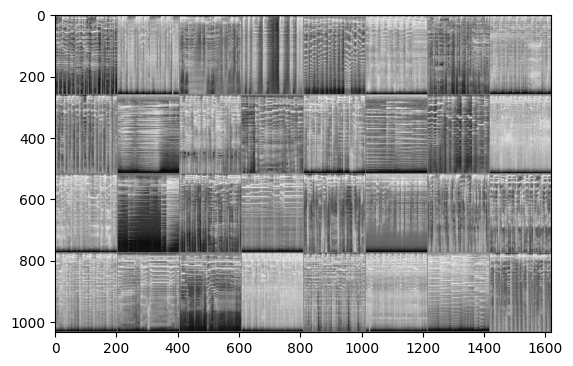

In [38]:
data = next(iter(trainloader))
images, labels = data[0].to(device), data[1].to(device)

imshow(torchvision.utils.make_grid(images.cpu()))

Get the numerical feature dataset

In [ ]:
transform = transforms.Normalize((0.5), (0.5))
ds = ds.NumericalFeatureDataset('features/features_30_sec.csv',
                                transform=transform)
v, l = ds[0]
print(v)
print(l)
print(v.shape)
trainloader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Create CNN and its optimizer

In [42]:
net = models.SpectCnn(img_w=spect_width, img_h=n_mels, num_channels=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=1e-5)

Train spectrogram CNN

In [43]:
epochs = 30
net.train_model(trainloader, epochs=epochs,
                loss_threshold=0.1,
                optimizer=optimizer,
                loss=criterion,
                device=device)

print('Finished Training')
torch.save(net.state_dict(), cnn_path)
print(f'Train accuracy: {net.validate(trainloader, device=device)}')
print(f'Test accuracy: {net.validate(testloader, device=device)}')

Epoch [1/30], Loss: 2.0126                   
Epoch [2/30], Loss: 1.9596                   
Epoch [3/30], Loss: 1.6058                   
Epoch [4/30], Loss: 1.3538                   
Epoch [5/30], Loss: 1.4167                   
Epoch [6/30], Loss: 1.3031                   
Epoch [7/30], Loss: 1.3375                   
Epoch [8/30], Loss: 0.9637                   
Epoch [9/30], Loss: 1.1991                   
Epoch [10/30], Loss: 0.9209                   
Epoch [11/30], Loss: 1.1352                   
Epoch [12/30], Loss: 0.8582                   
Epoch [13/30], Loss: 0.8950                   
Epoch [14/30], Loss: 1.4893                   
Epoch [15/30], Loss: 1.0021                   
Epoch [16/30], Loss: 0.8660                   
Epoch [17/30], Loss: 0.8235                   
Epoch [18/30], Loss: 0.8176                   
Epoch [19/30], Loss: 0.9533                   
Epoch [20/30], Loss: 0.4311                   
Epoch [21/30], Loss: 1.1703                   
Epoch [22/30], Loss: 0

Load and test CNN's accuracy

In [40]:
net.load_state_dict(torch.load(cnn_path, weights_only=True))
print(net)
print(f'Train accuracy: {net.validate(trainloader, device=device)}')
print(f'Test accuracy: {net.validate(testloader, device=device)}')

SpectCnn(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6144, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropou